In [116]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Testing
Some math concepts related to the circle search task. 

## Constructing input

In [151]:
_RED = [0, 1.0, 1.0]
_GREEN = [0.3, 1.0, 1.0]
_BLUE = [0.7, 1.0, 1.0]
_COLORS = [_RED, _GREEN, _BLUE]
_GRAY = [0, 0, 0.7]
_MAX_CONTACTS = 3
_N_CIRCLES = 18

fruits_rad = np.linspace(0 + (2 * np.pi / _N_CIRCLES), 2 * np.pi, _N_CIRCLES)
fruits_grid_x = 0.2 * np.cos(fruits_rad) + 0.5
fruits_grid_y = 0.2 * np.sin(fruits_rad) + 0.5
rot = np.random.randint(low=0, high=len(fruits_grid_x)-1, size=1)
print(rot)
fruits_grid_x = np.roll(fruits_grid_x, rot)
fruits_grid_y = np.roll(fruits_grid_y, rot)
fruits_colors_base = [_RED, _GREEN, _BLUE]
fruits_colors = np.repeat(fruits_colors_base, _N_CIRCLES/len(fruits_colors_base), axis=0)
fruits_colors_rot = np.roll(fruits_colors, rot, axis=0)

[12]


Input can be either an $N x N_c$ matrix, where $N$ is the number of possible positions and $N_c$ the number of possible colors. This is a one-hot encoding of the input. Alternatively, we can create a $N x 2$ list of tuples, where each element in the second array is a number corresponding to the color. Let's stick to the first one, since this should make it easier to do some operations later on. 

In [153]:
circle = np.zeros((len(_COLORS), _N_CIRCLES))
for i, color in enumerate(_COLORS):
    ixs = [(color == l_color).all() for l_color in fruits_colors_rot]    
    circle[i][ixs] = 1

In [154]:
prior_circle = np.zeros((len(_COLORS), _N_CIRCLES))
for i, color in enumerate(_COLORS):
    ixs = [(color == l_color).all() for l_color in fruits_colors]    
    prior_circle[i][ixs] = 1

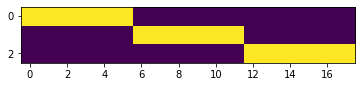

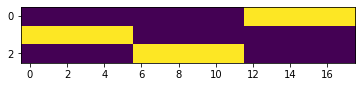

In [155]:
plt.imshow(prior_circle)
plt.show()
plt.imshow(circle)
plt.show()

So now we have a prior and the latent structure for an example trial. We should now construct a sample trial. This will consist of a tuple with a location in the first element and a color index in the second. We can generate this by randomly selecting a position and then finding the color at that position. 

In [162]:
p_t = np.random.randint(_N_CIRCLES, size=1)[0]
p_c = np.where(circle[:, p_t])[0][0]
e = (p_t, p_c)
print(e)

(17, 0)


So now we have evidence for a single trial. We can think of two different ways of estimating the correct angle for the next trial.

## Relational model

We can calculate (or remember) the pairwise angle offset between each color, and then apply this to the given angle find the correct offset. We'll need a method to find the COM of the target and source color in the prior, calculate the offset, and then return 

In [107]:
def _com(prior):
    return np.flatnonzero(prior).mean()
def relational(p_s, c_s, c_t, prior):
    n_colors, n_pos = prior.shape
    # find COM of source in prior
    com_source_prior = _com(prior[c_s])
    # find COM of target in prior
    com_target_prior = _com(prior[c_t])
    # calculate offset of colors in prior. this is approximately the angle between the two colors on the prior. 
    com_offset = com_target_prior - com_source_prior
    print(com_offset)
#     # find offset from COM of source color
#     cue_offset = p_s - com_source_prior 
#     print(cue_offset)
#     return n_pos % (com_source_prior + com_offset + cue_offset)
    return n_pos % (com_offset + p_s)

def eval(c_t, p_t):
    """Returns an error measure for target color and subject estimate"""
def allocentric(p_s, c_s, c_t, prior):
    # find angle rotation
    pass

In [108]:
relational(e[0], e[1], 2, prior_circle)

12.0


1.0

A few notes on the relational vs allocentric models
- The relational does not involve estimating the rotation. We do this by simply assuming that the given position is the center of mass for the source color
- In the allocentric, we do estimate the rotation and apply this to the prior over the source color. 
- I'm not sure what implications this will have in behavior, and what are other models we could construct

## Testing generalization

Let's consider a probabilistic, Bayesian model of the circle search problem. You're provided with some evidence in the form of a single point item in a distribution over possible angles. This can be a square distribution (1 at the location where the evidence is, zero otherwise) or Gaussian if we account for some noise in estimating the exact location of the evidence. 

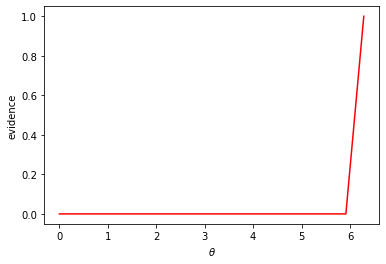

In [175]:
e_dist = np.zeros((_N_CIRCLES))
e_dist[e[0]] = 1
plt.plot(np.linspace(0, 2 * np.pi, _N_CIRCLES), e_dist, color=hsv_to_rgb(_COLORS[e[1]]))
plt.xlabel('$\\theta$')
plt.ylabel('evidence')
plt.show()

We also then have a map prior, which is a set of these distributions.

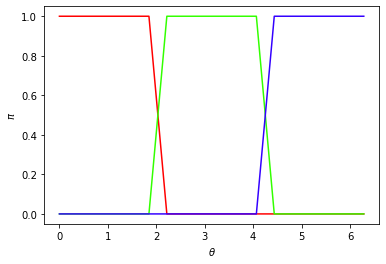

In [174]:
for i, c in enumerate(prior_circle):
    plt.plot(np.linspace(0, 2 * np.pi, _N_CIRCLES), c, color=hsv_to_rgb(_COLORS[i]))
plt.xlabel('$\\theta$')
plt.ylabel('$\pi$')
plt.show()

Estimating rotation via dot product of estimate and prior

In [165]:
norm_prior = prior_circle[e[1]]/np.linalg.norm(prior_circle[e[1]])
est_rot = np.arccos(np.dot(norm_prior, e_dist))
print(est_rot * 180 / np.pi)

90.0


Obtaining a distribution of possible rotations

In [170]:
rots = np.arange(_N_CIRCLES)
poss_rots = []
for rot in rots: 
    if np.dot(np.roll(prior_circle[e[1]], rot), e_dist) > 0:
        poss_rots.append(rot)
rots_dist = np.zeros(_N_CIRCLES)
rots_dist[poss_rots] = 1
rots_dist /= np.linalg.norm(rots_dist)

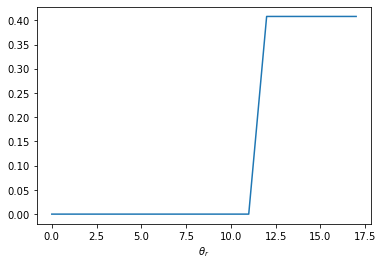

In [173]:
plt.plot(rots_dist)
plt.xlabel('$\\theta_r$')
plt.show()